faydalı olabilecek kaynaklar.

https://arxiv.org/pdf/2106.06910.pdf

https://dergipark.org.tr/tr/download/article-file/2250513

https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/   vader sentiment analiz için kullanılabilir

# First Looking at the data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Read CSV Files

In [2]:
covid_baby = pd.read_csv('data/covid_baby.csv', encoding='utf-8')
covid_baby2020 = pd.read_csv('data/covid_baby2020.csv', encoding='utf-8')
covid_birth = pd.read_csv('data/covid_birth.csv', encoding='utf-8')
covid_birth2020 = pd.read_csv('data/covid_birth2020.csv', encoding='utf-8')
covid_deliver = pd.read_csv('data/covid_deliver.csv', encoding='utf-8')
covid_deliver2020 = pd.read_csv('data/covid_deliver2020.csv', encoding='utf-8')
covid_newborn = pd.read_csv('data/covid_newborn.csv', encoding='utf-8')
covid_newborn2020 = pd.read_csv('data/covid_newborn2020.csv', encoding='utf-8')
covid_pregnancy = pd.read_csv('data/covid_pregnancy.csv', encoding='utf-8')
covid_pregnancy2020 = pd.read_csv('data/covid_pregnancy2020.csv', encoding='utf-8')
covid_pregnant = pd.read_csv('data/covid_pregnant.csv', encoding='utf-8')
covid_pregnant2020 = pd.read_csv('data/covid_pregnant2020.csv', encoding='utf-8')


In [3]:
# tweets by keywords
tweets_by_keywords = pd.DataFrame({'covid_baby': covid_baby.shape[0] + covid_baby2020.shape[0],
                                   'covid_birth': covid_birth.shape[0] + covid_birth2020.shape[0],
                                   'covid_deliver': covid_deliver.shape[0] + covid_deliver2020.shape[0],
                                   'covid_newborn': covid_newborn.shape[0] + covid_newborn2020.shape[0],
                                   'covid_pregnancy': covid_pregnancy.shape[0] + covid_pregnancy2020.shape[0],
                                   'covid_pregnant': covid_pregnant.shape[0] + covid_pregnant2020.shape[0]}, index=[0])


In [4]:
data = pd.concat([covid_baby, covid_baby2020, covid_birth, covid_birth2020, covid_deliver, covid_deliver2020, covid_newborn, covid_newborn2020, covid_pregnancy, covid_pregnancy2020, covid_pregnant, covid_pregnant2020], axis=0)

In [5]:
data.Tweet.duplicated().sum()

57787

In [6]:
data = data.drop_duplicates(subset=['Tweet'])

In [7]:
data.head()

,User,verified,Date_Created,Follows_Count,Friends_Count,Retweet_Count,Language,Date_Tweet,Number_of_Likes,Source_of_Tweet,Tweet_Id,Tweet,Hashtags,Conversation_Id,In_reply_To,Coordinates,Place
0,palermino_susan,False,2015-12-03 15:25:58+00:00,1561,2678,0,en,2022-11-30 23:58:11+00:00,0.0,Twitter for Android,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...,NaN,1.596073e+18,https://twitter.com/elonmusk,NaN,NaN
1,JoshL1220,False,2011-09-09 20:37:36+00:00,1664,800,0,en,2022-11-30 23:57:10+00:00,4.0,Twitter for Android,1.598104e+18,"Apparently ""I've had COVID for over a week and...",NaN,1.598104e+18,NaN,NaN,NaN
2,SierraMama55,False,2022-06-02 20:49:49+00:00,82,144,0,en,2022-11-30 23:54:03+00:00,1.0,Twitter for iPad,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...,NaN,1.595451e+18,https://twitter.com/snakewasright,NaN,NaN
3,Monocerotos69,False,2020-02-27 02:05:36+00:00,46,455,0,en,2022-11-30 23:52:17+00:00,0.0,Twitter for iPhone,1.598103e+18,They're dropping the sequel to COVID baby wooo...,NaN,1.598103e+18,NaN,NaN,NaN
4,Punkintweets,False,2010-04-12 22:30:55+00:00,1249,2732,0,en,2022-11-30 23:44:42+00:00,0.0,Twitter for iPhone,1.598101e+18,@1goodtern They drop dead one by one of post C...,NaN,1.597852e+18,https://twitter.com/1goodtern,NaN,NaN


In [8]:
# sadece dili ingilizce olanlar
data = data[data['Language'] == 'en']
data.shape

(448292, 17)

In [9]:
columns_to_drop = ['verified','Coordinates','In_reply_To','Language','Conversation_Id','Place']
df = data.drop(columns_to_drop, axis=1)
df.columns = df.columns.str.lower()

In [10]:
df.head()

,user,date_created,follows_count,friends_count,retweet_count,date_tweet,number_of_likes,source_of_tweet,tweet_id,tweet,hashtags
0,palermino_susan,2015-12-03 15:25:58+00:00,1561,2678,0,2022-11-30 23:58:11+00:00,0.0,Twitter for Android,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...,NaN
1,JoshL1220,2011-09-09 20:37:36+00:00,1664,800,0,2022-11-30 23:57:10+00:00,4.0,Twitter for Android,1.598104e+18,"Apparently ""I've had COVID for over a week and...",NaN
2,SierraMama55,2022-06-02 20:49:49+00:00,82,144,0,2022-11-30 23:54:03+00:00,1.0,Twitter for iPad,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...,NaN
3,Monocerotos69,2020-02-27 02:05:36+00:00,46,455,0,2022-11-30 23:52:17+00:00,0.0,Twitter for iPhone,1.598103e+18,They're dropping the sequel to COVID baby wooo...,NaN
4,Punkintweets,2010-04-12 22:30:55+00:00,1249,2732,0,2022-11-30 23:44:42+00:00,0.0,Twitter for iPhone,1.598101e+18,@1goodtern They drop dead one by one of post C...,NaN


# Metedoloji için Kullanılabilir

In [11]:
# kullanıcı sayısı ve tweet sayısı
print(f'{df.shape[0]} tweets from different {df.user.nunique()} unique users')

448292 tweets from different 293948 unique users


In [12]:
# # tweet sayısı ve kullanıcı sayısı oranları piechart  
# plt.figure(figsize=(10,10))
# plt.pie([df.user.nunique(), df.shape[0]], labels=['Unique Users', 'Tweets'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'],\
#  startangle=90, textprops={'fontsize': 14}, wedgeprops=dict(width=0.3), explode=(0.05,0), shadow=True, pctdistance=0.85,\
#     labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)

# # users_tweets_rate = pd.DataFrame({'User Numbers': df.user.nunique(), 'Tweet Numbers': len(df)}, index = range(0,1))\
# #                                     .T[0].plot.pie(figsize=(6,6), autopct='%1.1f%%', fontsize=15, colors=['#ff9999','#66b3ff'],\
# #                                             wedgeprops=dict(width=0.3), startangle=90, explode=(0.05,0), legend=True)
# plt.legend(loc='center')
# plt.show()                                            

## yıl ay gün analizi

In [13]:
df.date_tweet = pd.to_datetime(df.date_tweet)
df['year']= df.date_tweet.dt.year
df['month'] = df.date_tweet.dt.month_name()    
df['day'] = df.date_tweet.dt.day_name()
df.head()

,user,date_created,follows_count,friends_count,retweet_count,date_tweet,number_of_likes,source_of_tweet,tweet_id,tweet,hashtags,year,month,day
0,palermino_susan,2015-12-03 15:25:58+00:00,1561,2678,0,2022-11-30 23:58:11+00:00,0.0,Twitter for Android,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...,NaN,2022,November,Wednesday
1,JoshL1220,2011-09-09 20:37:36+00:00,1664,800,0,2022-11-30 23:57:10+00:00,4.0,Twitter for Android,1.598104e+18,"Apparently ""I've had COVID for over a week and...",NaN,2022,November,Wednesday
2,SierraMama55,2022-06-02 20:49:49+00:00,82,144,0,2022-11-30 23:54:03+00:00,1.0,Twitter for iPad,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...,NaN,2022,November,Wednesday
3,Monocerotos69,2020-02-27 02:05:36+00:00,46,455,0,2022-11-30 23:52:17+00:00,0.0,Twitter for iPhone,1.598103e+18,They're dropping the sequel to COVID baby wooo...,NaN,2022,November,Wednesday
4,Punkintweets,2010-04-12 22:30:55+00:00,1249,2732,0,2022-11-30 23:44:42+00:00,0.0,Twitter for iPhone,1.598101e+18,@1goodtern They drop dead one by one of post C...,NaN,2022,November,Wednesday


In [14]:
df['year'].value_counts()

2020    177700
2022    170436
2021    100156
Name: year, dtype: int64

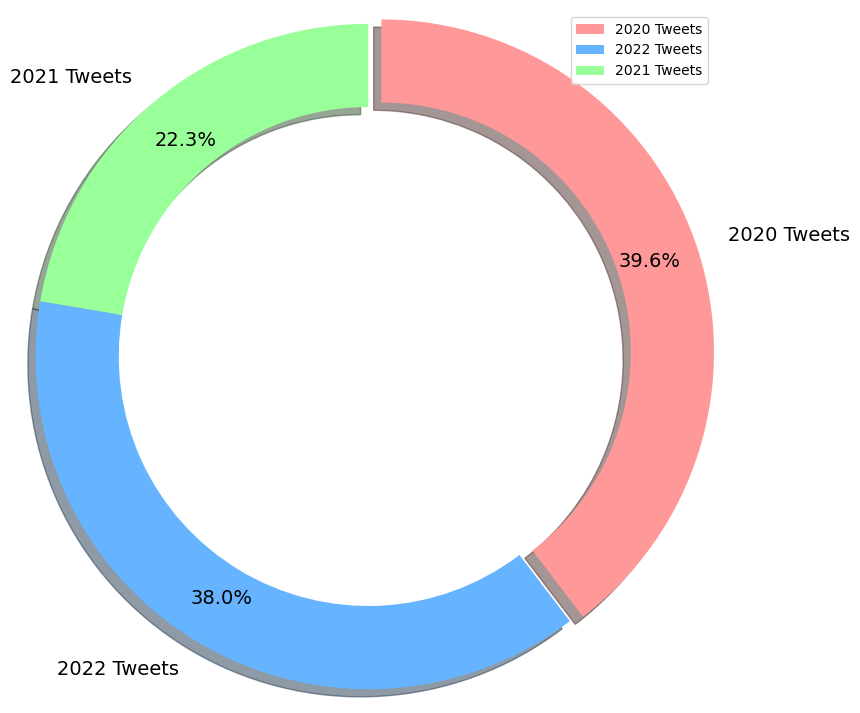

In [15]:
# Datada yer alan tweetlerin yıllara göre dağılımı
plt.figure(figsize=(9,9))
plt.pie(df.year.value_counts(), labels=['2020 Tweets', '2022 Tweets', '2021 Tweets'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'],\
 startangle=90, textprops={'fontsize': 14}, wedgeprops=dict(width=0.3), explode=(0.05,0,0), shadow=True, pctdistance=0.85,\
    labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)
plt.legend(loc='upper right')
plt.show()

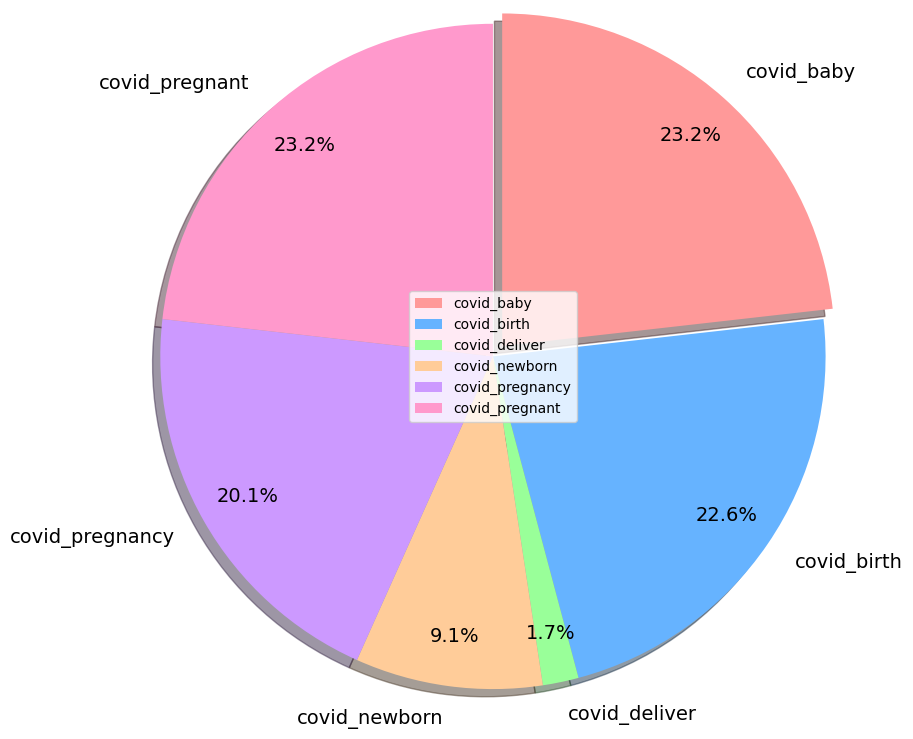

In [16]:
# tweetlerin anahtar kelimelere göre dağılımı
plt.figure(figsize=(9,9))
plt.pie(tweets_by_keywords.iloc[0], labels=['covid_baby', 'covid_birth', 'covid_deliver', 'covid_newborn', 'covid_pregnancy', 'covid_pregnant'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc'],\
    startangle=90, textprops={'fontsize': 14}, explode=(0.05,0,0,0,0,0), shadow=True, pctdistance=0.85,\
    labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)
plt.legend(loc='center')
plt.show()


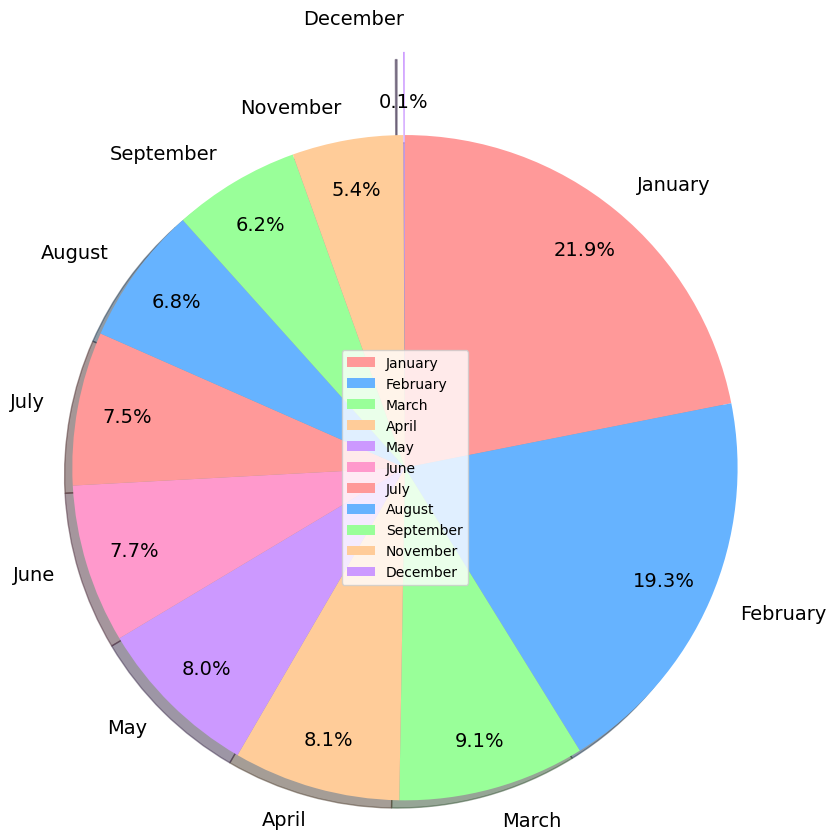

In [17]:
# tweetlerin aylara göre dağılımı
plt.figure(figsize=(9,9))
plt.pie(df[df['year']==2020].month.value_counts()[:11], labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'November', 'December'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc','#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc'],\
    startangle=90, textprops={'fontsize': 14}, explode=(0.0,0,0,0,0,0,0,0,0.0,0.0,0.3), shadow=True, pctdistance=0.85,\
    labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)
plt.legend(loc='center')
plt.show()


# not eğer bu analizi fayfalı bulursan diğer yılları ekleyebiliriz

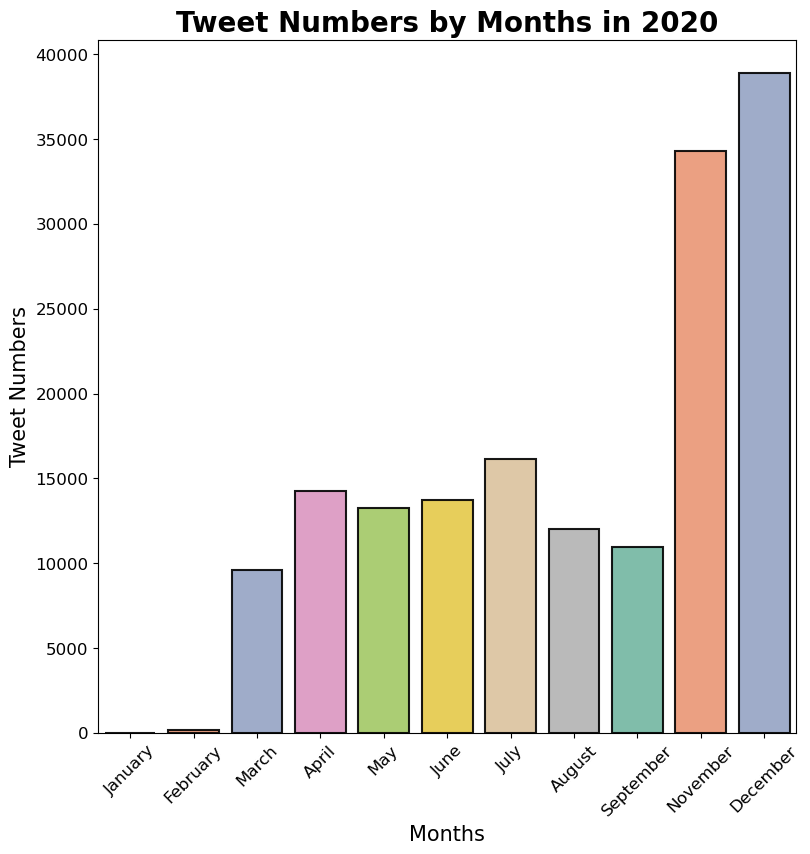

(<AxesSubplot: title={'center': 'Tweet Numbers by Months in 2020'}, xlabel='Months', ylabel='Tweet Numbers'>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
  [Text(0, 0, 'January'),
   Text(1, 0, 'February'),
   Text(2, 0, 'March'),
   Text(3, 0, 'April'),
   Text(4, 0, 'May'),
   Text(5, 0, 'June'),
   Text(6, 0, 'July'),
   Text(7, 0, 'August'),
   Text(8, 0, 'September'),
   Text(9, 0, 'November'),
   Text(10, 0, 'December')]),
 (array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
         40000., 45000.]),
  [Text(0, 0.0, '0'),
   Text(0, 5000.0, '5000'),
   Text(0, 10000.0, '10000'),
   Text(0, 15000.0, '15000'),
   Text(0, 20000.0, '20000'),
   Text(0, 25000.0, '25000'),
   Text(0, 30000.0, '30000'),
   Text(0, 35000.0, '35000'),
   Text(0, 40000.0, '40000'),
   Text(0, 45000.0, '45000')]),
 Text(0.5, 30.0, 'Months'),
 Text(30.0, 0.5, 'Tweet Numbers'),
 Text(0.5, 1.0, 'Tweet Numbers by Months in 2020'),
 None)

In [18]:

import seaborn as sns
plt.figure(figsize=(9,9))
sns.countplot(x='month', data=df[df['year']==2020], palette='Set2',\
    order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'November', 'December'],\
        edgecolor='black', linewidth=1.5, saturation=0.75, alpha=0.9),\
             plt.xticks(rotation=45, fontsize=12), plt.yticks(fontsize=12),\
                    plt.xlabel('Months', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
                        plt.title('Tweet Numbers by Months in 2020', fontsize=20, fontweight='bold'),\
plt.show()


# gerek görülürse diğer yıllar eklenebilir

In [19]:
df.head()

,user,date_created,follows_count,friends_count,retweet_count,date_tweet,number_of_likes,source_of_tweet,tweet_id,tweet,hashtags,year,month,day
0,palermino_susan,2015-12-03 15:25:58+00:00,1561,2678,0,2022-11-30 23:58:11+00:00,0.0,Twitter for Android,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...,NaN,2022,November,Wednesday
1,JoshL1220,2011-09-09 20:37:36+00:00,1664,800,0,2022-11-30 23:57:10+00:00,4.0,Twitter for Android,1.598104e+18,"Apparently ""I've had COVID for over a week and...",NaN,2022,November,Wednesday
2,SierraMama55,2022-06-02 20:49:49+00:00,82,144,0,2022-11-30 23:54:03+00:00,1.0,Twitter for iPad,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...,NaN,2022,November,Wednesday
3,Monocerotos69,2020-02-27 02:05:36+00:00,46,455,0,2022-11-30 23:52:17+00:00,0.0,Twitter for iPhone,1.598103e+18,They're dropping the sequel to COVID baby wooo...,NaN,2022,November,Wednesday
4,Punkintweets,2010-04-12 22:30:55+00:00,1249,2732,0,2022-11-30 23:44:42+00:00,0.0,Twitter for iPhone,1.598101e+18,@1goodtern They drop dead one by one of post C...,NaN,2022,November,Wednesday


# data temizleme

In [20]:
# url leri temizleme
import re
df['tweet'] = df['tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
# clean the emojis in the tweets
df['tweet'] = df['tweet'].apply(lambda x: re.sub('[^\w\s#@/:%.,_-]', '', str(x)))
# clean the mentions in the tweets
df['tweet'] = df['tweet'].apply(lambda x: re.sub('@[^\s]+','',str(x)))
# clean the new lien charecter
df['tweet'] = df['tweet'].apply(lambda x: re.sub('\n',' ',str(x)))
# clean the white spaces in the tweets
df['tweet'] = df['tweet'].apply(lambda x: re.sub(' +',' ',str(x)))
# clean space in the begining and end of the tweets
df['tweet'] = df['tweet'].apply(lambda x: x.strip())



In [21]:
# amp karakterini içeren tweetlerin sayısı
df[df['tweet'].str.contains(r'\bamp\b')].shape[0]

35191

In [22]:
# clean ampersand from the tweets
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\bamp\b', '', str(x)))
df[df['tweet'].str.contains(r'\bamp\b')].shape[0]

0

In [23]:
# first, drop nan values in the tweet column
df.dropna(subset=['tweet'], inplace=True)

In [24]:
df.tweet.duplicated().sum()

56314

In [25]:
# duplicate tweetlerin silinmesi
df.drop_duplicates(subset=['tweet'], inplace=True)

In [26]:
# tek kelimelik tweetlerin silinmesi
df = df[df['tweet'].str.split().str.len() > 1]

tek kelimelik tweetleri düşmemizin nedeni: corpusumuda yer alan
tweetlerin token uzunluklarını hesaplayıp belli bir token sayısının altında
olan tweetlerin silinmesine karar vermek için istatistikleri olumsuz etkileyecek olan tek kelimelik 
tweetlerin etkisini kaldırmak içindi.

Sadece token sayısına göre twitter'ın karakter sınırlamasını göz önüne aldığımızda tek başına
yeterli bir ölçek olmayacaktır. Bu yüzden karakter sayılarını da hesaplayıp token sayıları ile karşılaştırıp
daha mantıklı bir çıkarım yapmış oluruz.

In [27]:
df['token_numbers'] = df.tweet.map(lambda x: len(x.strip().split()))
df['char_numbers'] = df.tweet.map(lambda x: len(x.strip()))
df.head()

,user,date_created,follows_count,friends_count,retweet_count,date_tweet,number_of_likes,source_of_tweet,tweet_id,tweet,hashtags,year,month,day,token_numbers,char_numbers
0,palermino_susan,2015-12-03 15:25:58+00:00,1561,2678,0,2022-11-30 23:58:11+00:00,0.0,Twitter for Android,1.598104e+18,I thunk youre an irresponsible for allowing an...,NaN,2022,November,Wednesday,50,279
1,JoshL1220,2011-09-09 20:37:36+00:00,1664,800,0,2022-11-30 23:57:10+00:00,4.0,Twitter for Android,1.598104e+18,Apparently Ive had COVID for over a week and I...,NaN,2022,November,Wednesday,32,164
2,SierraMama55,2022-06-02 20:49:49+00:00,82,144,0,2022-11-30 23:54:03+00:00,1.0,Twitter for iPad,1.598103e+18,"Yeah, its easier to believe that Democrats eat...",NaN,2022,November,Wednesday,50,275
3,Monocerotos69,2020-02-27 02:05:36+00:00,46,455,0,2022-11-30 23:52:17+00:00,0.0,Twitter for iPhone,1.598103e+18,Theyre dropping the sequel to COVID baby woooo...,NaN,2022,November,Wednesday,8,50
4,Punkintweets,2010-04-12 22:30:55+00:00,1249,2732,0,2022-11-30 23:44:42+00:00,0.0,Twitter for iPhone,1.598101e+18,They drop dead one by one of post COVID cardia...,NaN,2022,November,Wednesday,15,72


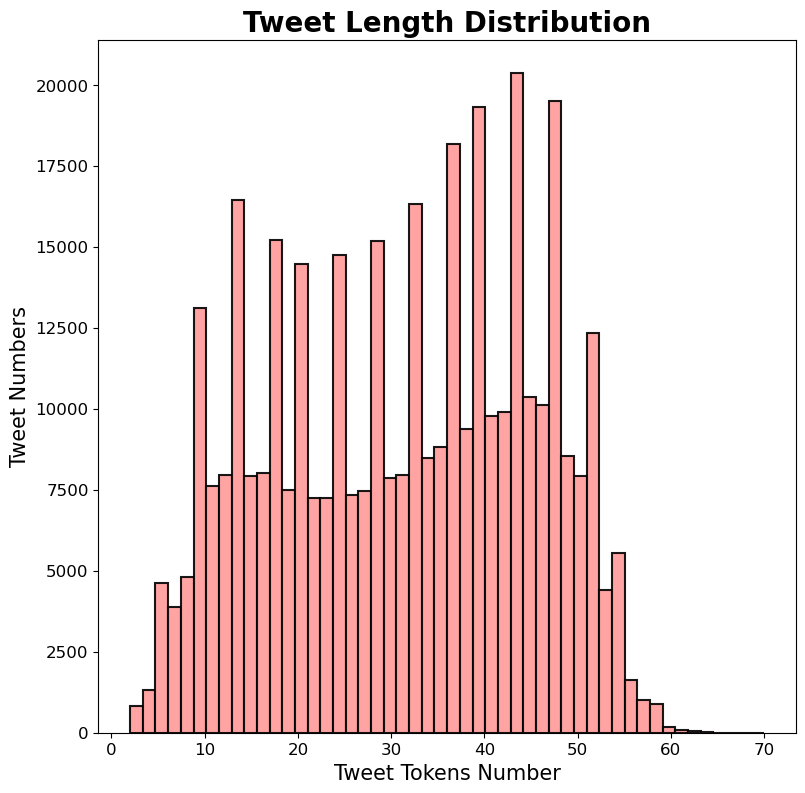

In [28]:
# tweetlerin token sayılarına göre dağılımı
plt.figure(figsize=(9,9))
plt.hist(df.token_numbers, bins=50, color='#ff9999', edgecolor='black', linewidth=1.5, alpha=0.9)
plt.xticks(fontsize=12), plt.yticks(fontsize=12), plt.xlabel('Tweet Tokens Number', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
    plt.title('Tweet Length Distribution', fontsize=20, fontweight='bold')
plt.show()

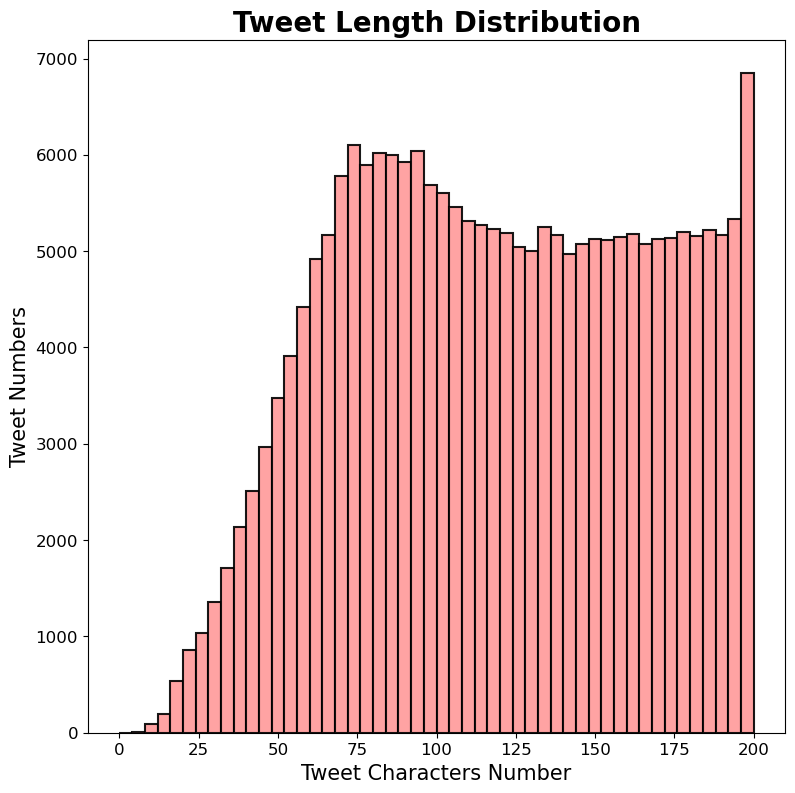

In [29]:
# tweetlerin karakter sayılarına göre dağılımı
plt.figure(figsize=(9,9))
plt.hist(df.char_numbers, bins=50, color='#ff9999', edgecolor='black', linewidth=1.5, alpha=0.9, range=(0,200))
plt.xticks(fontsize=12), plt.yticks(fontsize=12), plt.xlabel('Tweet Characters Number', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
    plt.title('Tweet Length Distribution', fontsize=20, fontweight='bold')
plt.show()

In [30]:
df.char_numbers.describe()

count    391885.000000
mean        177.564038
std          75.167288
min           4.000000
25%         111.000000
50%         187.000000
75%         249.000000
max         290.000000
Name: char_numbers, dtype: float64

In [31]:
# tweetlerin karakter sayılarına göre aykırı değerlerin hesaplanması
Q1 = df.char_numbers.quantile(0.25)
Q3 = df.char_numbers.quantile(0.75)
IQR = Q3 - Q1
print('Q1 (%25): ', Q1)
print('Q3 (75) : ', Q3)




Q1 (%25):  111.0
Q3 (75) :  249.0


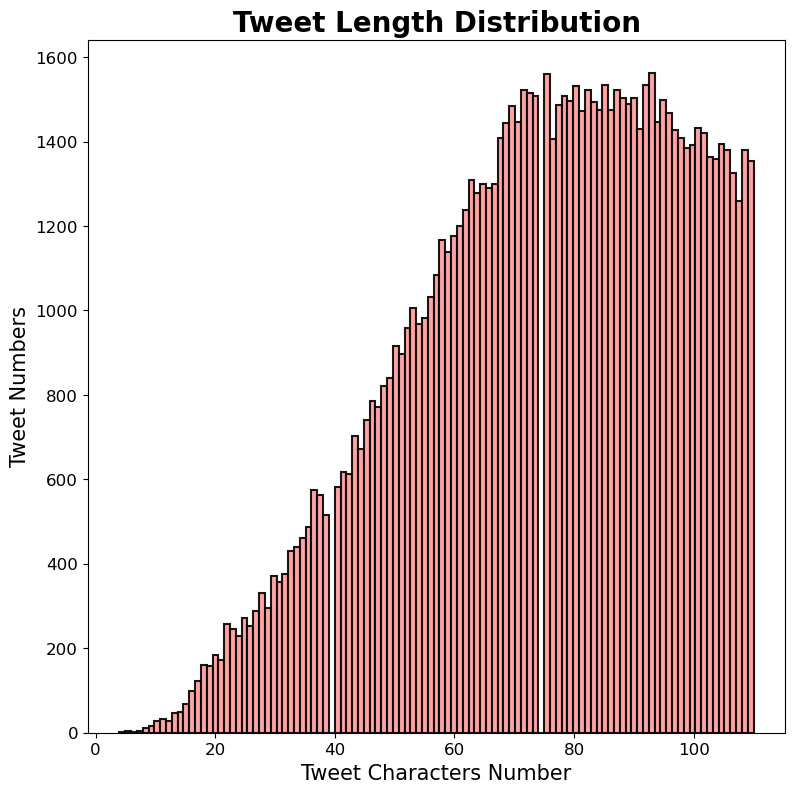

In [32]:
# Q1 (%25) altındaki değerler ve token sayılarının dağılımı
plt.figure(figsize=(9,9))
plt.hist(df[df['char_numbers']<Q1].char_numbers, bins=109, color='#ff9999', edgecolor='black', linewidth=1.5, alpha=0.9)
plt.xticks(fontsize=12), plt.yticks(fontsize=12), plt.xlabel('Tweet Characters Number', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
    plt.title('Tweet Length Distribution', fontsize=20, fontweight='bold')
plt.show()


In [33]:
# Q1 değerinden daha az karakter sayısına sahip olan tweetlerin istatisliksel olarak incelenmesi
df[df['char_numbers'] < Q1]['char_numbers'].describe()


count    97840.000000
mean        74.561948
std         22.568611
min          4.000000
25%         59.000000
50%         77.000000
75%         93.000000
max        110.000000
Name: char_numbers, dtype: float64

In [34]:
df[df['char_numbers']>58].tweet.sample(10).values

array(['girls gays theys charlies mum AND my mum both have covid and they really want you to buy conscious and earthbound on Bandcamp for 1 to make them feel like their babies are not failures so, youre kinda obliged',
       'Im blessed to be in a wealthy school district that provides vaccines  Covid testing to every teacher and student. Students cant return if positive  over 90% of my kids are fully vaccinated. But if that wasnt the case theres no way my pregnant ass would be returning.',
       'My family of four just had covid. My 8month old daughter and 3 yr old daughter were FINE 3 days later, unvaccinated. Vaccinated babies for Covid is insane',
       'Baby formula shortage, stopping drilling and fracking for oil and gas, border security, covid response, inflation reduction act, any bill repubs support at first, they touch it and add onto it and then claim repubs are against it for its original purpose.',
       'Best advices for pregnant women during Coronavirus pandemic: #Hij

In [37]:
# son olarak karakter sayısı 59 ve 59 dan fazla olan tweetleri corpusumuza dahil ediyoruz
df = df[df['char_numbers']>58]
df.shape

(367800, 16)

In [36]:
df.to_csv('cleaned_twitter_corpus.csv', index=False)